# Marche avec un modèle simplifié 

Ce notebook sert d'introduction à l'utilisation de **modèle simplifié de type pendule inverse** pour la **locomotion des robots bipède**. L'exercice consiste à calculer **la trajectoire optimale du centre de masse** (COM) du robot puis à contrôler le robot par **cinématique inverse** pour réaliser le mouvement souhaité.


## Définition du problème

On définit classiquement un robot, affiché dans meshcat, et un plan de locomotion définissant les phases de contact successives par leur durée, le pied de support et le déplacement du pied de vol.

In [4]:
# %load tp4/generated/simple_walk_import
import time
from collections import namedtuple

import example_robot_data as robex
import matplotlib.pyplot as plt
import numpy as np
import pinocchio as pin
import proxsuite
from numpy.linalg import pinv

from schaeffler2025.meshcat_viewer_wrapper import MeshcatVisualizer

np.set_printoptions(precision=3, linewidth=350, suppress=True, threshold=1e6)

# --- Load robot model
robot = robex.load("talos")
model = robot.model
data = model.createData()
NQ = model.nq
NV = model.nv

# Open the viewer
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

feetIndexes = {
    "right": robot.model.getFrameId("right_sole_link"),
    "left": robot.model.getFrameId("left_sole_link"),
}


*** You asked to start meshcat "classically" in tcp://127.0.0.1:6000
*** Did you start meshcat manually (meshcat-server)
Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [5]:
# %load tp4/generated/simple_walk_phases
# Structure to define a phase of locomotion
Phase = namedtuple("Phase", ["duration", "delta", "support"])

# Definition of the task
comVelocity = np.array([0.25, 0, 0])
stepDuration = 0.8
step = comVelocity[:2] * stepDuration * 2
phases = [
    Phase(stepDuration * 2, np.zeros(2), "double"),
    Phase(stepDuration / 2, step / 2, "right"),
    Phase(stepDuration, step, "left"),
    Phase(stepDuration, step, "right"),
    Phase(stepDuration, step, "left"),
    Phase(stepDuration, step, "right"),
    Phase(stepDuration / 2, step / 2, "left"),
    Phase(stepDuration * 2, np.zeros(2), "double"),
]
DT = 6e-2


La marche sera réalisée par deux calculs bien séparés:
- d'une part, la formulation et la résolution d'un problème de contrôle optimal, pour choisir la trajectoire du COM sur un horizon permettant de garder sa stabilité malgré les efforts limités que le robot peut appliquer au sol
- puis une cinématique inverse permettant de déduire le mouvement du corps complet pour suivre les trajectoires de référence.

Lors d'une implémentation complète, le contrôle optimal est résolu en ligne, à chaque état du robot, implémentant **un contrôleur prédictif** qui est seul à même de garantir une marche robuste. Ici, par simplicité, la trajectoire n'est optimisée qu'une seule fois en début de mouvement. 

## Trajectoire optimale du pendule inverse

Il y a plusieurs trajectoires à calculer successivement:
- la position des pieds de support, et à partir de ces positions, la trajectoire de référence de chaque pied
- le centre du polygone de support à chaque instant, où le centre de pression du système serait idéalement placé pour maximiser la robustesse
- on peut alors optimiser la trajectoire du COM, comme un compromis entre la position du COP correspondante (COP au plus proche du COP de référence) et la faisabilité du mouvement (COM allant dans la bonne direction, avec une de ses dérivées, par exemple accélération ou jerk, minimisée)



### Trajectoire des pieds et COP de référence

Les calculs ici sont très arbitraires, et principalement des choix géométriques simples. 

En préambule, il faut effectuer quelques calculs de cinématique directe pour avoir les grandeurs initiales (positions des pieds, hauteur du centre de marche, fréquence de chute ...).

In [8]:
# %load tp4/generated/simple_walk_init
q = robot.q0.copy()
pin.computeAllTerms(model, data, q, np.zeros(NV))
pin.framesForwardKinematics(model, data, q)
com0 = data.com[0].copy()[:2]
right0 = data.oMf[feetIndexes["right"]].translation.copy()[:2]
left0 = data.oMf[feetIndexes["left"]].translation.copy()[:2]
omega2 = -model.gravity.linear[2] / data.com[0][2]


On peut alors calculer les trajectoires des pieds et la référence du COP. Pour garder l'exercice compact, on a choisi des interpolations linéaires pour les pieds ... marche mode "traine savate".

In [14]:
# %load tp4/generated/simple_walk_feet_refs
times = [0]
right_refs = [right0.copy()]
left_refs = [left0.copy()]
cop_refs = [np.mean([right0, left0], 0)]
for phase in phases:
    times.extend([times[-1] + t for t in np.arange(DT, phase.duration + DT, DT)])
    delta = phase.delta / phase.duration
    right_refs.extend(
        [
            right_refs[-1] + (delta * t if phase.support == "left" else 0)
            for t in np.arange(DT, phase.duration + DT, DT)
        ]
    )
    left_refs.extend(
        [
            left_refs[-1] + (delta * t if phase.support == "right" else 0)
            for t in np.arange(DT, phase.duration + DT, DT)
        ]
    )
    cop_refs.extend(
        [
            right_refs[-1]
            if phase.support == "right"
            else left_refs[-1]
            if phase.support == "left"
            else np.mean([right_refs[-1], left_refs[-1]], 0)
            for t in np.arange(0, phase.duration, DT)
        ]
    )


Voici un aperçu du résultat.

Text(0.5, 0, 'Time')

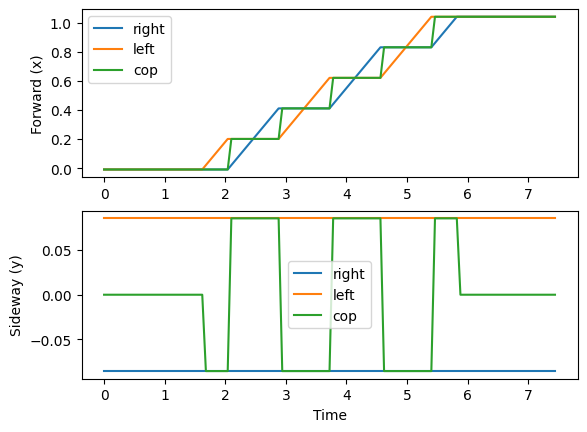

In [17]:
# %load tp4/generated/simple_walk_fig1
plt.figure(1)
plt.subplot(211)
plt.plot(times, [r[0] for r in right_refs])
plt.plot(times, [r[0] for r in left_refs])
plt.plot(times, [r[0] for r in cop_refs])
plt.legend(["right", "left", "cop"])
plt.ylabel('Forward (x)')
plt.subplot(212)
plt.plot(times, [r[1] for r in right_refs])
plt.plot(times, [r[1] for r in left_refs])
plt.plot(times, [r[1] for r in cop_refs])
plt.legend(["right", "left", "cop"])
plt.ylabel('Sideway (y)')
plt.xlabel('Time')


### Formulation du problème de contrôle optimal

Le problème s'écrit:

$$\min_{\{c\},\{z\}} \sum_{t=0}^{T} w_{c} || \ddot{c}_t ||^2 + || z_t - z_t^* ||^2$$

où $c$ est le COM, $z$ le COP, $\{c\}$ et $\{z\}$ représente les trajectoires de ces deux quantités et de leurs dérivés, et la dynamique doit respecter : 

$$ \ddot{c}_t = \omega^2 (c_t-z_t)$$
$$ c_0 = c(q_0)$$

On a aussi bien sûr des contraintes sur les dérivées de $c$, qui doivent résulter d'une intégration numérique correcte, par exemple celle d'un intégrateur Euler.
$$ c_{t+1} = c_t + \dot{c}_t DT$$
etc.

In [24]:
# %load tp4/generated/simple_walk_ocp_header
T = len(times)
WEIGHT_LEAST_MOTION = 5e-3  # best jerk
WITH_JERK = False


On formule d'abord les blocs correspondants aux coûts et contraintes à chaque instant.

In [25]:
# %load tp4/generated/simple_walk_ocp_blocks
w2 = omega2
w4 = w2**2
Lcom = WEIGHT_LEAST_MOTION * np.array([[w4, 0, -w4], [0, 0, 0], [-w4, 0, w4]])
Lcop = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]])
Fy = np.array([[1, DT, 0], [w2 * DT, 1, -w2 * DT]])
# Implicit integration in option:
# Fy += np.array([ [w2*DT**2,0,-w2*DT**2].[0,0,0] ])


On peut alors remplir les matrices $H,g,F,f$ du QP suivant:

$$\min{x} \frac{1}{2} x^T H x + g^T x $$

tel que $$F x = f$$

In [26]:
# %load tp4/generated/simple_walk_matrices
Hessian = [np.zeros([T * 3, T * 3]) for _ in range(2)]
gradient = [np.zeros(T * 3) for _ in range(2)]
Jacobian = [np.zeros([T * 2, T * 3]) for _ in range(2)]
gap = [np.zeros(T * 2) for _ in range(2)]
for k, cop in enumerate(cop_refs):
    # For each direction forward(x) / sideway(y)
    for d in range(2):
        # Hessian of OCP
        Hessian[d][3 * k : 3 * k + 3, 3 * k : 3 * k + 3] = Lcom + Lcop
        # Minimum acceleration or minimum jerk?
        if WITH_JERK and k > 0:
            Hessian[d][3 * k - 3 : 3 * k, 3 * k : 3 * k + 3] = -Lcom
            Hessian[d][3 * k : 3 * k + 3, 3 * k - 3 : 3 * k] = -Lcom
        # Gradient of OCP
        gradient[d][3 * k + 2] = -cop[d]

        Jacobian[d][2 * k : 2 * k + 2, 3 * k : 3 * k + 3] = np.eye(3)[:2]
        if k > 0:
            Jacobian[d][2 * k : 2 * k + 2, 3 * k - 3 : 3 * k] = -Fy
        else:
            gap[d][:2] = [com0[d], 0]


### Résolution de l'OCP

Le gros intérêt du modèle du pendule inverse est qu'il induit un problème quadratique, très facile à résoudre. On utilise ici Prox-QP pour le résoudre.

In [28]:
# %load tp4/generated/simple_walk_solve
qp = [proxsuite.proxqp.dense.QP(T * 3, T * 2, 0, False) for d in range(2)]
for d in range(2):
    qp[d].settings.eps_abs = 1e-12
    qp[d].init(Hessian[d], gradient[d], Jacobian[d], gap[d])
    qp[d].solve()


Voici un apercu du résultat.

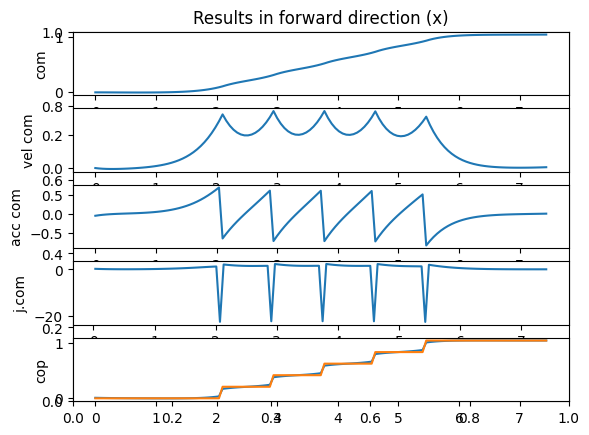

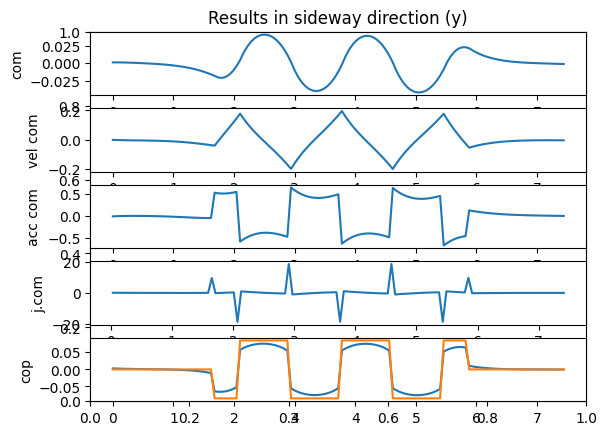

In [30]:
# %load tp4/generated/simple_walk_fig2
for d in range(2):
    plt.figure(2 + d)
    if d == 0:
        plt.title("Results in forward direction (x)")
    else:
        plt.title("Results in sideway direction (y)")

    plt.subplot(511)
    plt.plot(times, qp[d].results.x[::3])
    plt.ylabel("com")
    plt.subplot(512)
    plt.plot(times, qp[d].results.x[1::3])
    plt.ylabel("vel com")
    plt.subplot(513)
    acc = omega2 * (qp[d].results.x[::3] - qp[d].results.x[2::3])
    plt.plot(times, acc)
    plt.ylabel("acc com")
    plt.subplot(514)
    jerk = (acc[1:] - acc[:-1]) / DT
    plt.plot(np.array(times[1:]) - DT / 2, jerk)
    plt.ylabel("j.com")
    plt.subplot(515)
    plt.plot(times, qp[d].results.x[2::3])
    plt.plot(times, [c[d] for c in cop_refs])
    plt.ylabel("cop")


Text(0, 0.5, 'sideway (y)')

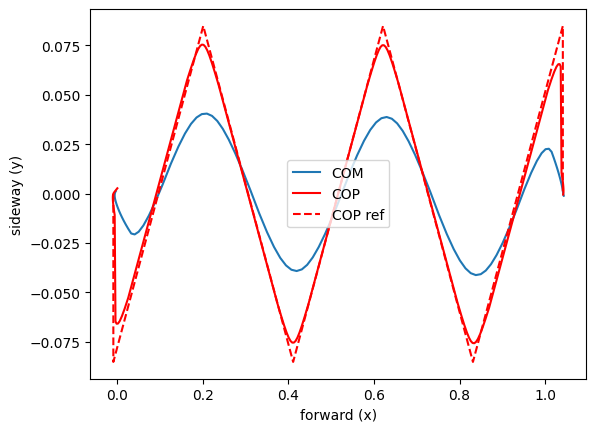

In [32]:
# %load tp4/generated/simple_walk_fig3
plt.figure(4)
plt.plot(qp[0].results.x[::3], qp[1].results.x[::3])
plt.plot(qp[0].results.x[2::3], qp[1].results.x[2::3], "r")
plt.plot([c[0] for c in cop_refs], [c[1] for c in cop_refs], "r--")
plt.legend(["COM", "COP", "COP ref"])
plt.xlabel("forward (x)")
plt.ylabel("sideway (y)")


## Cinématique inverse

Il n'y a plus qu'à calculer le mouvement du corps complet du robot par cinématique inverse. La suite est une variation de l'exercice précédent, cette fois avec un terme correcteur pour suivre les trajectoires calculées.

In [34]:
# %load tp4/generated/simple_walk_ik
for k, t in enumerate(times):
    # Pre-compute kinematics, jacobians, com etc
    pin.computeAllTerms(model, data, q, np.zeros(NV))

    # Right foot
    edot_right = right_refs[k] - data.oMf[feetIndexes["right"]].translation[:2]
    edot_right = np.r_[edot_right, [0, 0, 0, 0]]  # Make it 6D
    J_right = pin.getFrameJacobian(model, data, feetIndexes["right"], pin.LOCAL)
    # Left foot
    edot_left = left_refs[k] - data.oMf[feetIndexes["left"]].translation[:2]
    J_left = pin.getFrameJacobian(model, data, feetIndexes["left"], pin.LOCAL)
    edot_left = np.r_[edot_left, [0, 0, 0, 0]]  # Make it 6D
    # COM
    com_ref = np.r_[qp[0].results.x[k * 3], qp[1].results.x[k * 3]]
    edot_com = com_ref - data.com[0][:2]
    J_com = pin.jacobianCenterOfMass(model, data, q)[:2]

    edot = 5 * np.r_[edot_right, edot_left, edot_com]
    J = np.r_[J_right, J_left, J_com]

    vq = pinv(J) @ edot
    q = pin.integrate(model, q, vq * DT)
    viz.display(q)
    time.sleep(DT)


La cinématique inverse est ici particulièrement simplifiée. Sur le vrai robot, on prendra soit de décider l'accéleration articulaire plutôt que la vitesse, éventuellement dans une dynamique inverse permettant de contraindre les couples articulaires ou les forces de contact de respecter le modèle physique. 